# Settings

In [1]:
EXP_NO = 5
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = True

# Library

In [2]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.feature import hog
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from dataset import load_csvfiles, load_photofile
from folder import experiment_dir_of
from target import soring_date2target

In [3]:
pd.options.display.float_format = '{:.5f}'.format

# Prepare directory

In [4]:
output_dir = experiment_dir_of(EXP_NO)

In [5]:
output_dir

'..\\scripts\\..\\experiments\\exp005'

# Prepare logger

In [6]:
logger = getLogger(__name__)

In [7]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [8]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-17 12:20:00,085 - __main__ - INFO - Experiment no: 5
2021-07-17 12:20:00,088 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-17 12:20:00,090 - __main__ - INFO - SEED: 1
2021-07-17 12:20:00,090 - __main__ - INFO - REGRESSION: True


# Load csv files

In [9]:
SINCE = time.time()

In [10]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-17 12:20:00,120 - __main__ - DEBUG - Start loading csv files (0.018 seconds passed)
2021-07-17 12:20:00,150 - __main__ - DEBUG - Complete loading csv files (0.048 seconds passed)


In [11]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [12]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Feature engineering

## Extract hog features

In [13]:
%%time
train_hog_features = {object_id: hog(load_photofile(object_id)) for object_id in train['object_id']}

Wall time: 1min 57s


In [14]:
%%time
X_test = np.array([hog(load_photofile(object_id)) for object_id in test['object_id']])

Wall time: 2min 40s


# Cross validation

In [15]:
train.set_index('object_id', inplace=True)

In [16]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))
    # Separate dataset into training/validation fold
    X_train = np.array([train_hog_features[object_id] for object_id in train_object_ids])
    y_train = train.loc[train_object_ids, TARGET].values
    X_valid = np.array([train_hog_features[object_id] for object_id in valid_object_ids])
    y_valid = train.loc[valid_object_ids, TARGET].values
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## train estimator
    estimator = SVR(C=10.0)
    estimator.fit(X_train, y_train)
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    
    # Save model and prediction
    ## Prediction
    if REGRESSION:
        pred_train = pd.DataFrame(data=estimator.predict(X_train), columns=['pred'])
        pred_valid = pd.DataFrame(data=estimator.predict(X_valid), columns=['pred'])
        pred_test = pd.DataFrame(data=estimator.predict(X_test), columns=['pred'])
    else:
        try:
            pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                                     columns=estimator.classes_)
        except AttributeError:
            pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
                                     columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'wb') as f:
        pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, X_train, X_valid, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

2021-07-17 12:24:37,841 - __main__ - DEBUG - Start fold 1 (277.739 seconds passed)
2021-07-17 12:24:38,327 - __main__ - DEBUG - Start training model (278.225 seconds passed)
2021-07-17 12:27:19,781 - __main__ - DEBUG - Complete training (439.679 seconds passed)
2021-07-17 12:53:12,874 - __main__ - DEBUG - Save training fold to ..\scripts\..\experiments\exp005\cv_fold1_training.csv (1992.772 seconds passed)
2021-07-17 12:53:12,887 - __main__ - DEBUG - Save validation fold to ..\scripts\..\experiments\exp005\cv_fold1_validation.csv (1992.785 seconds passed)
2021-07-17 12:53:12,908 - __main__ - DEBUG - Save test result ..\scripts\..\experiments\exp005\cv_fold1_test.csv (1992.806 seconds passed)
2021-07-17 12:53:14,652 - __main__ - DEBUG - Save model ..\scripts\..\experiments\exp005\cv_fold1_model.pkl (1994.550 seconds passed)
2021-07-17 12:53:14,969 - __main__ - DEBUG - Complete fold 1 (1994.867 seconds passed)
2021-07-17 12:53:14,970 - __main__ - DEBUG - Start fold 2 (1994.868 seconds pa

# Evaluation

In [17]:
rmse = partial(mean_squared_error, squared=False)

In [18]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [19]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [20]:
metrics = defaultdict(list)

## Training set

In [22]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-17 14:49:58,945 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-17 14:49:58,962 - __main__ - DEBUG - Loss: 0.09712644639680812
2021-07-17 14:49:58,962 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-17 14:49:58,983 - __main__ - DEBUG - Loss: 0.09689172531694361
2021-07-17 14:49:58,984 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-17 14:49:59,003 - __main__ - DEBUG - Loss: 0.096923820045827
2021-07-17 14:49:59,004 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-17 14:49:59,021 - __main__ - DEBUG - Loss: 0.09678045458616119
2021-07-17 14:49:59,022 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-17 14:49:59,037 - __main__ - DEBUG - Loss: 0.09679259492795053


In [23]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
pred_train

,pred,actual
object_id,,
002bff09b09998d0be65,0.88003,1
00309fb1ef05416f9c1f,2.31995,3
003a1562e97f79ba96dc,2.31990,3
004890880e8e7431147b,1.61608,2
00718c32602425f504c1,2.31992,3
...,...,...
ffa3259fff8e6f3818a1,2.32002,3
ffd4d361756587883e48,0.78508,1
ffd794b7b311b7b7fd92,1.62801,2


In [24]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-17 14:50:26,042 - __main__ - INFO - Training loss: 0.44743747074769724


In [25]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-17 14:50:32,133 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp005\prediction_train.csv


## Validation set

In [26]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-17 14:50:38,214 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-17 14:50:38,234 - __main__ - DEBUG - Loss: 0.880233549632057
2021-07-17 14:50:38,235 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-17 14:50:38,251 - __main__ - DEBUG - Loss: 0.8757126387134911
2021-07-17 14:50:38,252 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-17 14:50:38,267 - __main__ - DEBUG - Loss: 0.8994909482092113
2021-07-17 14:50:38,268 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-17 14:50:38,281 - __main__ - DEBUG - Loss: 0.8798904898969909
2021-07-17 14:50:38,282 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-17 14:50:38,295 - __main__ - DEBUG - Loss: 0.8695488210625281


In [28]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
pred_valid

,pred,actual
object_id,,
002bff09b09998d0be65,0.26919,1
00309fb1ef05416f9c1f,0.31565,3
003a1562e97f79ba96dc,0.51940,3
004890880e8e7431147b,0.38355,2
00718c32602425f504c1,0.43963,3
...,...,...
ffa3259fff8e6f3818a1,0.45523,3
ffd4d361756587883e48,0.21003,1
ffd794b7b311b7b7fd92,0.40163,2


In [30]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

2021-07-17 14:51:15,865 - __main__ - INFO - Validatino loss: 1.718037060990645


In [31]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-17 14:51:19,678 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp005\prediction_valid.csv


In [32]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-17 14:51:20,187 - __main__ - DEBUG - Write metrics to ..\scripts\..\experiments\exp005\metrics.json


# Prediction

In [33]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [36]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,pred
object_id,
0009e50b94be36ccad39,1.44202
000bd5e82eb22f199f44,1.40205
0015f44de1854f617516,1.73833
00388a678879ba1efa27,1.58365
005e1e7c6496902d23f3,1.22484
...,...
ffbe65ad399b632dcbd0,2.62890
ffd7b2d646c0320c311a,1.51921
ffdb93ede17d4501e530,1.92078


In [37]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1.44202
1,1.40205
2,1.73833
3,1.58365
4,1.22484
...,...
5914,2.62890
5915,1.51921
5916,1.92078
5917,1.82371


In [38]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [39]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-17 14:52:23,518 - __main__ - DEBUG - Write submission to ..\scripts\..\experiments\exp005\005_submission.csv


2021-07-17 14:53:14,354 - __main__ - DEBUG - Write figure to ..\scripts\..\experiments\exp005\prediction.png


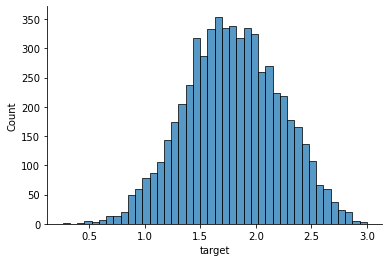

In [40]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [41]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-17 14:53:21,506 - __main__ - DEBUG - Complete (9201.403 seconds passed)
